## Data Loading

In [350]:
from azure.storage.filedatalake import DataLakeServiceClient

from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv('notebooks/corrected/.env')

# Replace with your details
storage_account_name = "mldebugdevadls"
storage_account_key = os.getenv('AZURE_STORAGE_KEY')

# Connect to ADLS
service_client = DataLakeServiceClient(
    account_url=f"https://{storage_account_name}.dfs.core.windows.net",
    credential=storage_account_key,
    api_version="2023-11-03"  # Use the correct supported API version
)

# List Containers
containers = service_client.list_file_systems()
for container in containers:
    print(container.name)


data


In [302]:
# Replace with your details
container_name = "data"

In [303]:
import os
from azure.storage.blob import BlobServiceClient
import pandas as pd
import io

def read_csv_from_blob(storage_account_name, container_name, file_name, storage_account_key=None):
    """
    Read a CSV file from Azure Blob Storage using Python and return a Pandas DataFrame.

    :param storage_account_name: Azure storage account name.
    :param container_name: Blob container name.
    :param file_name: Name of the file in the container.
    :param storage_account_key: Storage account access key.
    :return: Pandas DataFrame.
    """
    
    if not storage_account_key:
        # Try to get the key from environment variables if not provided
        storage_account_key = os.environ.get('AZURE_STORAGE_KEY')
        
    if not storage_account_key:
        raise ValueError("Storage account key must be provided either as a parameter or as an environment variable 'AZURE_STORAGE_KEY'")
    
    try:
        # Create a connection string
        connection_string = f"DefaultEndpointsProtocol=https;AccountName={storage_account_name};AccountKey={storage_account_key};EndpointSuffix=core.windows.net"
        
        # Create the BlobServiceClient
        blob_service_client = BlobServiceClient.from_connection_string(connection_string)
        
        # Get the container client
        container_client = blob_service_client.get_container_client(container_name)
        
        # Get the blob client
        blob_client = container_client.get_blob_client(file_name)
        
        # Download the blob content
        download_stream = blob_client.download_blob()
        
        # Convert the content to a DataFrame
        content = download_stream.readall()
        df = pd.read_csv(io.BytesIO(content))
        
        return df
    
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return None

In [304]:
online_marketing = read_csv_from_blob(storage_account_name=storage_account_name,
                                      container_name=container_name, 
                                      file_name="OnlineMarketingData.csv",
                                      storage_account_key=storage_account_key)
offline_marketing = read_csv_from_blob(storage_account_name=storage_account_name,
                                      container_name=container_name, 
                                      file_name="OfflineMarketingData.csv",
                                      storage_account_key=storage_account_key)
sales = read_csv_from_blob(storage_account_name=storage_account_name,
                                      container_name=container_name, 
                                      file_name="SalesData.csv",
                                      storage_account_key=storage_account_key)
price = read_csv_from_blob(storage_account_name=storage_account_name,
                                      container_name=container_name, 
                                      file_name="PricingData.csv",
                                      storage_account_key=storage_account_key)

## Importing libraries 

In [305]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

In [351]:
sales_data = sales.copy()
offline_data = offline_marketing.copy()
online_data = online_marketing.copy()
digital_data = online_marketing.copy()
price_data = price.copy()

In [352]:
# Read sales data and convert to date to datetime
sales_data['date'] =  pd.to_datetime(sales_data['date'])

#read offline marketing data and convert week to datetime
offline_data['week'] = pd.to_datetime(offline_data['week'])

#read online marketing data and convert to datetime
digital_data['date'] = pd.to_datetime(digital_data['date'])

# Convert date to datetime
price_data['date'] = pd.to_datetime(price_data['date'])


In [308]:

# Convert store_id to categorical column
sales_data['store_id'] = sales_data['store_id'].astype('category')


In [154]:
from ydata_profiling import ProfileReport

competitors_data_profile = ProfileReport(sales_data, title='Sales Data Report', explorative=True)
competitors_data_profile.config.vars.num.low_categorical_threshold = 30

competitors_data_profile.to_file('data/report/sales_data_report.html')

Export report to file: 100%|████████████████████| 1/1 [00:00<00:00, 250.17it/s]


In [155]:
from ydata_profiling import ProfileReport

offline_data_profile = ProfileReport(offline_data, title='Offline Data Report', explorative=True)
offline_data_profile.config.vars.num.low_categorical_threshold = 30

offline_data_profile.to_file('data/report/offline_data_report.html')

Export report to file: 100%|████████████████████| 1/1 [00:00<00:00, 166.66it/s]


In [35]:
from ydata_profiling import ProfileReport

online_data_profile = ProfileReport(online_data, title='Online Data Report', explorative=True)
online_data_profile.config.vars.num.low_categorical_threshold = 30

online_data_profile.to_file('data/report/online_data_report.html')

Export report to file: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 77.27it/s]


In [353]:
from ydata_profiling import ProfileReport

price_data_profile = ProfileReport(price_data, title='Price Data Report', explorative=True)
price_data_profile.config.vars.num.low_categorical_threshold = 30

price_data_profile.to_file('data/report/price_data_report.html')

Export report to file: 100%|█████████████████████| 1/1 [00:00<00:00, 41.67it/s]


## Task 1: Time Series Visualization with Misaligned Time Frequencies and Scale Differences

In [309]:
offline_data.head()

,week,channel,spend
0,2023-01-01,TV,11311.42
1,2023-01-01,Radio,6723.33
2,2023-01-01,Print,6214.43
3,2023-01-01,OOH,11230.47
4,2023-01-08,TV,14004.01


In [310]:
sales_data.head()

,date,city,state,store_id,product_id,sales_quantity
0,2023-01-01,Mumbai,Maharashtra,MUM_01,P001,112
1,2023-01-01,Mumbai,Maharashtra,MUM_01,P002,100
2,2023-01-01,Mumbai,Maharashtra,MUM_01,P003,126
3,2023-01-01,Mumbai,Maharashtra,MUM_01,P004,108
4,2023-01-01,Mumbai,Maharashtra,MUM_01,P005,129


In [311]:
# Calculate total daily sales to match with marketing data
daily_sales = sales_data.groupby('date')['sales_quantity'].sum().reset_index()
daily_sales.rename(columns={'sales_quantity': 'total_sales'}, inplace=True)

In [312]:
daily_sales.head()

,date,total_sales
0,2023-01-01,143153
1,2023-01-02,145152
2,2023-01-03,144708
3,2023-01-04,143017
4,2023-01-05,145002


In [313]:
# Merge digital data with daily sales for analysis
digital_sales = pd.merge(digital_data, daily_sales, on='date', how='left')

In [314]:
digital_sales.head()

,date,channel,spend,impressions,clicks,total_sales
0,2023-01-01,Facebook,1152.82,20117,613,143153
1,2023-01-01,Instagram,707.48,9760,196,143153
2,2023-01-01,YouTube,703.13,11148,236,143153
3,2023-01-01,Google Ads,810.68,12761,553,143153
4,2023-01-01,Influencer Marketing,1122.12,22415,554,143153


In [315]:
# Aggregate weekly sales for comparison with weekly media spend and start week on Sunday
weekly_sales = daily_sales.copy()
weekly_sales['week'] = pd.to_datetime(weekly_sales['date']).dt.to_period('W-SAT').dt.start_time
weekly_sales = weekly_sales.groupby('week')['total_sales'].sum().reset_index()

In [316]:
weekly_sales.head()

,week,total_sales
0,2023-01-01,1005836
1,2023-01-08,1010621
2,2023-01-15,1007025
3,2023-01-22,1006524
4,2023-01-29,1004040


In [317]:
# Merge weekly media spend with weekly sales
media_sales = pd.merge(offline_data, weekly_sales, on='week', how='left')

In [318]:
media_sales.head()

,week,channel,spend,total_sales
0,2023-01-01,TV,11311.42,1005836
1,2023-01-01,Radio,6723.33,1005836
2,2023-01-01,Print,6214.43,1005836
3,2023-01-01,OOH,11230.47,1005836
4,2023-01-08,TV,14004.01,1010621


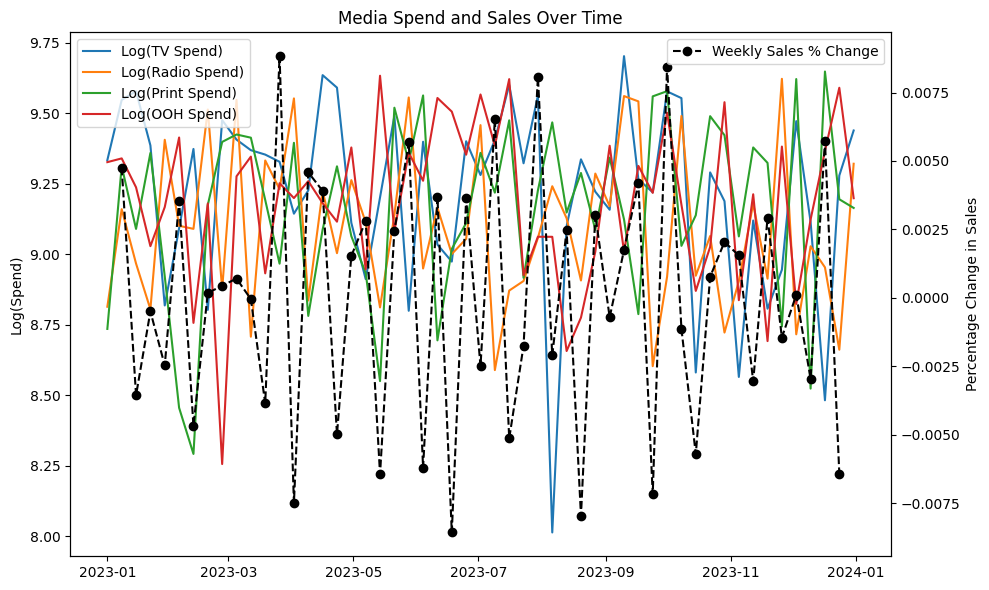

In [319]:
%matplotlib inline
import numpy as np

def plot_time_series_corrected():
    # Pivot the media data to have channels as columns
    offline_data_pivoted = offline_data.pivot_table(index='week', columns='channel', values='spend', aggfunc='sum')

    # Plot the media spend and sales over time
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot log-transformed offline media spend on primary y-axis
    ax1.plot(offline_data_pivoted.index, np.log1p(offline_data_pivoted['TV']), label='Log(TV Spend)')
    ax1.plot(offline_data_pivoted.index, np.log1p(offline_data_pivoted['Radio']), label='Log(Radio Spend)')
    ax1.plot(offline_data_pivoted.index, np.log1p(offline_data_pivoted['Print']), label='Log(Print Spend)')
    ax1.plot(offline_data_pivoted.index, np.log1p(offline_data_pivoted['OOH']), label='Log(OOH Spend)')
    ax1.set_ylabel('Log(Spend)')
    ax1.legend(loc='upper left')

    # Remove the first value (outlier) from weekly_sales before plotting
    weekly_sales_no_outlier = weekly_sales.iloc[:-1].reset_index(drop=True)

    # Plot log-transformed weekly sales on secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(
        weekly_sales_no_outlier['week'],
        weekly_sales_no_outlier['total_sales'].pct_change(),
        color='black',
        linestyle='--',
        marker='o',
        label='Weekly Sales % Change'
    )
    ax2.set_ylabel('Weekly Sales % Change')
    ax2.legend(loc='lower right')

    # Add titles and labels
    plt.title('Media Spend and Sales Over Time')
    plt.xlabel('Week')
    plt.ylabel('Percentage Change in Sales')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_time_series_corrected()

## Task 2: Incorrect Correlation Analysis with Mixed Frequency Data

In [320]:
offline_data = pd.read_csv('data/OfflineMarketingData.csv')
digital_data = pd.read_csv('data/OnlineMarketingData.csv')

In [321]:
# Pivot the media data to have channels as columns
offline_data_pivoted = offline_data.pivot_table(index='week', columns='channel', values='spend', aggfunc='sum')

# Align with the digital data (ensure we match by the correct index)
# Assuming digital_data has 'date' and 'clicks', we can group by date and align with weeks if necessary
clicks_data = digital_data.groupby('date', as_index=False)['clicks'].sum()  # Ensure it’s aligned by date

In [322]:
clicks_data.head()

,date,clicks
0,2023-01-01,2152
1,2023-01-02,2132
2,2023-01-03,2025
3,2023-01-04,2357
4,2023-01-05,2918


In [323]:
offline_data_pivoted.head()

channel,OOH,Print,Radio,TV
week,,,,
2023-01-01,11230.47,6214.43,6723.33,11311.42
2023-01-08,11380.75,11069.60,9505.50,14004.01
2023-01-15,10270.30,8861.17,7836.04,14442.24
2023-01-22,8335.56,11601.91,6663.51,11917.89
2023-01-29,9575.21,7488.18,12158.00,6753.84


In [324]:
# convert week to datetime
offline_data['week'] = pd.to_datetime(offline_data['week']).dt.strftime('%Y-%m-%d')
offline_data.head()

,week,channel,spend
0,2023-01-01,TV,11311.42
1,2023-01-01,Radio,6723.33
2,2023-01-01,Print,6214.43
3,2023-01-01,OOH,11230.47
4,2023-01-08,TV,14004.01


In [325]:
clicks_data['date'] = pd.to_datetime(clicks_data['date']).dt.strftime('%Y-%m-%d')
clicks_data.head()

,date,clicks
0,2023-01-01,2152
1,2023-01-02,2132
2,2023-01-03,2025
3,2023-01-04,2357
4,2023-01-05,2918


In [326]:
weekly_click_data = clicks_data.copy()
weekly_click_data['week'] = pd.to_datetime(weekly_click_data['date']).dt.to_period('W-SAT').dt.start_time
weekly_click_data['week'] = weekly_click_data['week'].dt.strftime('%Y-%m-%d')
weekly_click_data.head()

,date,clicks,week
0,2023-01-01,2152,2023-01-01
1,2023-01-02,2132,2023-01-01
2,2023-01-03,2025,2023-01-01
3,2023-01-04,2357,2023-01-01
4,2023-01-05,2918,2023-01-01


In [327]:
# group by week
weekly_click_data = weekly_click_data.groupby('week')['clicks'].sum().reset_index()
weekly_click_data.head()

,week,clicks
0,2023-01-01,15716
1,2023-01-08,16657
2,2023-01-15,17233
3,2023-01-22,16365
4,2023-01-29,14444


In [328]:
offline_data_pivoted = offline_data.pivot_table(index='week', columns='channel', values='spend', aggfunc='sum')
offline_data_pivoted.head()

channel,OOH,Print,Radio,TV
week,,,,
2023-01-01,11230.47,6214.43,6723.33,11311.42
2023-01-08,11380.75,11069.60,9505.50,14004.01
2023-01-15,10270.30,8861.17,7836.04,14442.24
2023-01-22,8335.56,11601.91,6663.51,11917.89
2023-01-29,9575.21,7488.18,12158.00,6753.84


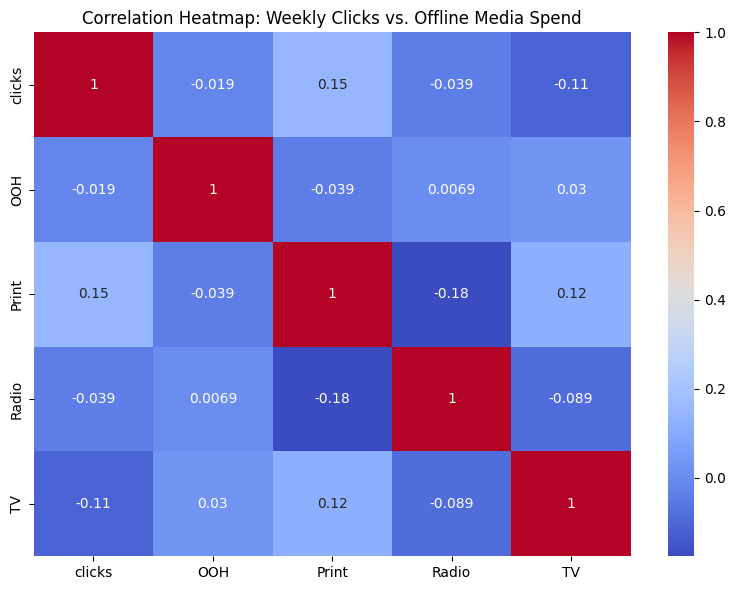

In [329]:
def plot_correlation_corrected():
    # Merge weekly_click_data with offline_data_pivoted on week
    merged = weekly_click_data.merge(
        offline_data_pivoted.reset_index(),
        left_on='week',
        right_on='week',
        how='inner'
    )

    # Set week as index and create correlation matrix
    merged_corr = merged.set_index('week')[['clicks', 'OOH', 'Print', 'Radio', 'TV']].corr()

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(merged_corr, annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap: Weekly Clicks vs. Offline Media Spend')
    plt.tight_layout()
    plt.show()

# # Call the function to demonstrate the corrected plot
plot_correlation_corrected()


## Task 3: Misleading Seasonality Analysis

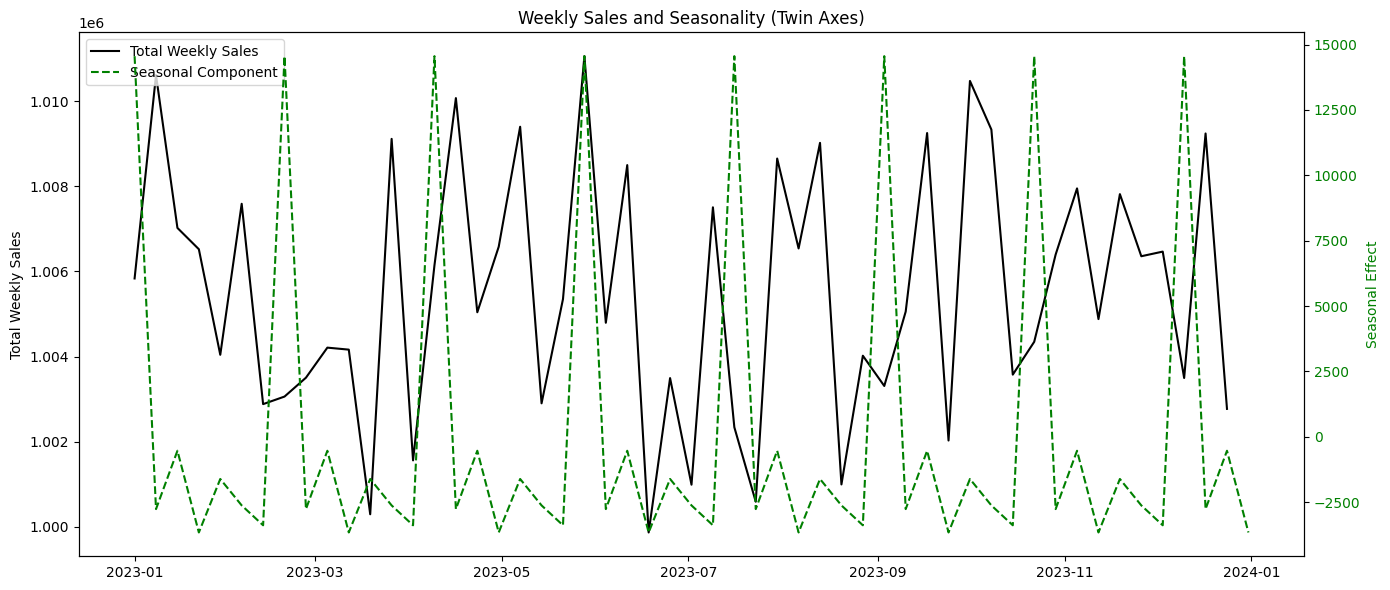

In [340]:
from statsmodels.tsa.seasonal import seasonal_decompose


def plot_seasonality_corrected(daily_sales):
  
    # Convert date to datetime
    daily_sales['date'] = pd.to_datetime(daily_sales['date'])
    
    # Sort by date
    daily_sales = daily_sales.set_index('date').sort_index()
    
    # Group by week
    daily_sales['week'] = daily_sales.index.to_period('W-SAT').start_time
    weekly_sales = daily_sales.groupby('week')['total_sales'].sum().reset_index()
    
    # Decompose (7-day period for weekly seasonality)
    decomposition = seasonal_decompose(weekly_sales['total_sales'], model='additive', period=7)
    
    # Extract seasonal component
    seasonal  = decomposition.seasonal
    
    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Plot total weekly sales on primary y-axis
    ax1.plot(weekly_sales['week'][:-1], weekly_sales['total_sales'][:-1], color='black', label='Total Weekly Sales')
    ax1.set_ylabel('Total Weekly Sales', color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    # Plot seasonal component on secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(weekly_sales['week'], seasonal, color='green', linestyle='--', label='Seasonal Component')
    ax2.set_ylabel('Seasonal Effect', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    # Legends for both axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

    plt.title('Weekly Sales and Seasonality (Twin Axes)')
    plt.xlabel('Week')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
  
# Call the function to demonstrate the corrected plot
plot_seasonality_corrected(daily_sales)


In [285]:
def plot_buggy_seasonality():
    # Resample sales to weekly for analysis - but choose wrong frequency
    weekly_sales = daily_sales.copy()
    weekly_sales.set_index('date', inplace=True)
    weekly_sales = weekly_sales.resample('W').sum().reset_index()  # Using week ending Sunday

    # Attempt decomposition without proper time series formatting
    plt.figure(figsize=(12, 6))
    plt.plot(weekly_sales['date'], weekly_sales['total_sales'])

    # Add arbitrary seasonal lines without statistical basis
    seasonal_pattern = np.sin(np.linspace(0, 4*np.pi, len(weekly_sales))) * 50 + 150
    plt.plot(weekly_sales['date'], seasonal_pattern, 'r--', label='Assumed Seasonality')

    plt.title('Buggy Seasonality Analysis')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.tight_layout()
    plt.show()


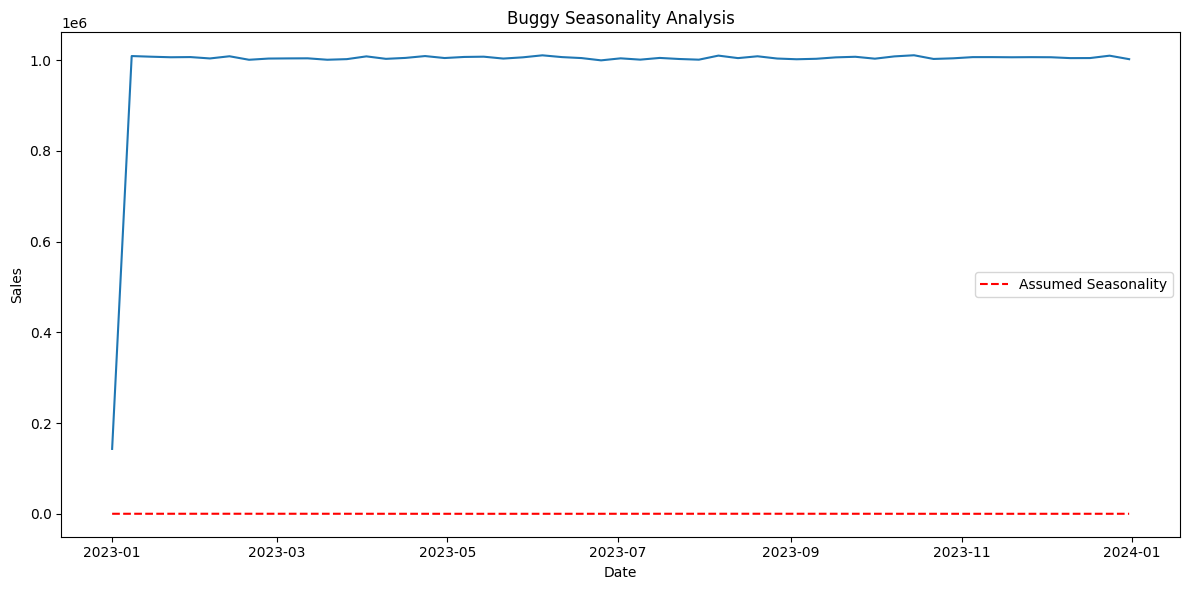

In [286]:
plot_buggy_seasonality()

## Task 4: Incorrect Assessment of Advertising Efficiency

In [344]:
print(digital_data.head())

         date               channel    spend  impressions  clicks       cpc
0  2023-01-01              Facebook  1152.82        20117     613  1.880620
1  2023-01-01             Instagram   707.48         9760     196  3.609592
2  2023-01-01               YouTube   703.13        11148     236  2.979364
3  2023-01-01            Google Ads   810.68        12761     553  1.465967
4  2023-01-01  Influencer Marketing  1122.12        22415     554  2.025487


In [347]:
agg = digital_data.groupby('channel').agg({'spend': 'sum', 'clicks': 'sum'}).reset_index()
# Calculate CPC for each channel
agg['cpc'] = agg['spend'] / agg['clicks']

agg

,channel,spend,clicks,cpc
0,Facebook,363003.65,157101,2.310639
1,Google Ads,364031.12,161619,2.252403
2,Influencer Marketing,363844.87,166931,2.179612
3,Instagram,368647.46,169209,2.178652
4,YouTube,364460.69,161439,2.257575


In [348]:

def plot_efficiency_corrected():
    # Aggregate spend and clicks per channel
    agg = digital_data.groupby('channel').agg({'spend': 'sum', 'clicks': 'sum'}).reset_index()
    # Calculate CPC for each channel
    agg['cpc'] = agg['spend'] / agg['clicks']
    # Plot CPC per channel
    plt.figure(figsize=(10, 6))
    sns.barplot(x='channel', y='cpc', data=agg)
    plt.title('Cost Per Click by Channel')
    plt.xlabel('Channel')
    plt.ylabel('CPC ($)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


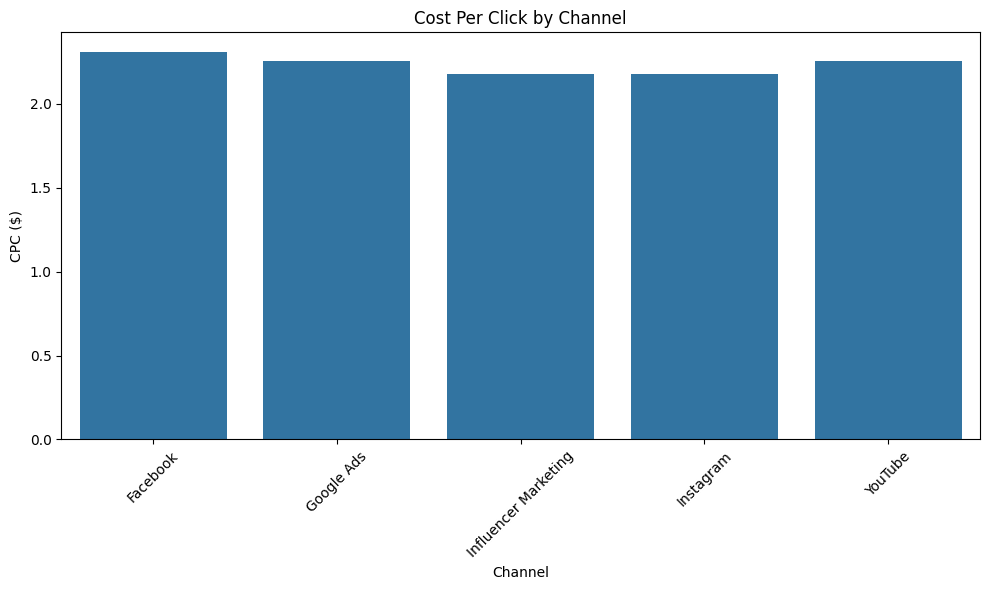

In [349]:
plot_efficiency_corrected()